In [87]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets

In [89]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [88]:
### FOLDER SETTINGS ###
input_folder = "../output/"

file_solution_path = input_folder + "/system_solution.dat"  # Replace with your actual file path
rhs_path = input_folder + "/system_rhs.dat"  # Replace with your actual file path
residual_path = input_folder + "/system_residual.dat"  # Replace with your actual file path

In [86]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [92]:
### Analytical solution functions ###

# This function creates a ND numpy array
def np_u_analytical_poisson(ndims, global_domain_begin, global_domain_end, grid_size, t):
    # Create coordinate arrays for each dimension
    p_coords = [np.linspace(global_domain_begin[i], global_domain_end[i], grid_size[i]) for i in range(ndims)]
    
    # Generate meshgrid from coordinate arrays
    meshgrid = np.meshgrid(*p_coords, indexing='ij')
    
    # Compute function values
    #func_val = np.prod(np.sin(np.pi * np.stack(meshgrid)),axis=0)
    #func_val = (np.sin(np.pi * meshgrid[1]) * np.sin(2 * np.pi * meshgrid[0]) + meshgrid[1] * np.sin(np.pi * meshgrid[0])) * np.cos(t)
    func_val = np.exp(t)*np.sin(meshgrid[1]) * np.sin(meshgrid[0])
    
    return func_val, meshgrid

In [90]:
### PLOTTING FUNCTIONS ###

def plot_1D(true_solution, approximate_solution):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2) #/ (grid_size[0] * grid_size[1])
    print(f"Max error: {np.max(error):.1e}, L2-error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    x_values = np.arange(len(true_solution))

    # True solution plot
    axes[0].scatter(x_values, true_solution, color='blue', linestyle='--', label='True Solution')
    axes[0].set_title('True Solution')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()

    # Approximate solution plot
    axes[1].scatter(x_values, approximate_solution, color='green', linestyle='--', label='Approximate Solution')
    axes[1].set_title('Approximate Solution')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].legend()

    # Error plot
    axes[2].scatter(x_values, error, color='red', linestyle='--', label='Error')
    axes[2].set_title('Error')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def plot_2D(true_solution, approximate_solution):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2)
    print(f"Max error: {np.max(error):.1e}, L2-error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot
    cax1 = axes[0].imshow(true_solution, cmap='viridis', aspect='auto', origin='lower')
    axes[0].set_title('True Solution')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot
    cax2 = axes[1].imshow(approximate_solution, cmap='viridis', aspect='auto', origin='lower')
    axes[1].set_title('Approximate Solution')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot
    cax3 = axes[2].imshow(error, cmap='hot', aspect='auto', origin='lower')
    axes[2].set_title('Error')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

def plot_slice_3D(true_solution, approximate_solution, z_index=0):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2) #/ (grid_size[0] * grid_size[1])
    print(f"Max error: {np.max(error):.1e}, L2-error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot for the given slice
    cax1 = axes[0].imshow(true_solution[:, :, z_index], cmap='viridis', origin='lower')
    axes[0].set_title(f'True Solution (Slice at z={z_index})')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot for the given slice
    cax2 = axes[1].imshow(approximate_solution[:, :, z_index], cmap='viridis', origin='lower')
    axes[1].set_title(f'Approximate Solution (Slice at z={z_index})')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot for the given slice
    cax3 = axes[2].imshow(error[:, :, z_index], cmap='hot', origin='lower')
    axes[2].set_title(f'Error (Slice at z={z_index})')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

In [93]:
data = np.fromfile(file_solution_path, dtype=np.float64)
approximate_solution = np.array(data)

data = np.fromfile(rhs_path, dtype=np.float64)
rhs = np.array(data)

data = np.fromfile(residual_path, dtype=np.float64)
residual = np.array(data)

In [91]:
ndims = 2
num_data_per_elements = 1
grid_size = [32,32,4]

if(ndims == 1):
    layout = (grid_size[0], num_data_per_elements)

if(ndims == 2):
    layout = (grid_size[0], grid_size[1], num_data_per_elements)

if(ndims == 3):
    layout = (grid_size[0], grid_size[1], grid_size[2], num_data_per_elements)

print("Layout: ", layout)

Layout:  (32, 32, 1)


In [94]:
# Reshape the data into a 2D array
approximate_solution = np.array(approximate_solution)
rhs = np.array(rhs)
residual = np.array(residual)

approximate_solution = approximate_solution.reshape(layout)
rhs = rhs.reshape(layout)
residual = residual.reshape(layout)

approximate_solution = np.squeeze(approximate_solution)
rhs = np.squeeze(rhs)
residual = np.squeeze(residual)
print(approximate_solution.shape)

(32, 32)


In [97]:
#print(approximate_solution.T)

In [96]:
#print(rhs.T)

In [95]:
# Iterative solver with multigrid(W-cycle 2-step) on the unsymmetric 2D-Poisson problem
# NxM, stencil size, Max error, L2 error

# 16x16, 3x3, 1.3e-02, 9.4e-02
# 32x32, 3x3, 3.1e-03, 4.5e-02
# 64x64, 3x3, 7.5e-04, 2.2e-02

# 16x16, 5x5, 6.6e-04, 3.2e-03
# 32x32, 5x5, 2.5e-05, 2.2e-04
# 64x64, 5x5, 8.1e-07, 1.9e-05

# 16x16, 7x7, 6.3e-05, 3.7e-04
# 32x32, 7x7, 8.6e-07, 1.0e-05
# 64x64, 7x7, 4.8e-08, 1.3e-06

In [99]:
# Direct solver for the unsymmetric 2D-Poisson problem

# NxM, stencil size, Max error, L2 error

# 16x16, 3x3, 1.3e-02, 9.4e-02
# 32x32, 3x3, 3.1e-03, 4.5e-02
# 64x64, 3x3, 7.5e-04, 2.2e-02
# 128x128, 3x3, 1.8e-04, 1.1e-02

# 16x16, 5x5, 6.6e-04, 3.2e-03
# 32x32, 5x5, 2.5e-05, 2.2e-04
# 64x64, 5x5, 8.1e-07, 1.9e-05
# 128x128, 5x5, 4.4e-08, 2.6e-06

# 16x16, 7x7, 6.3e-05, 3.7e-04
# 32x32, 7x7, 8.6e-07, 1.0e-05
# 64x64, 7x7, 7.1e-09, 1.8e-07
# 128x128, 7x7, 3.4e-10, 3.6e-09

# 16x16, 9x9, 1.0e-06, 5.6e-06
# 32x32, 9x9, 2.8e-08, 3.1e-07
# 64x64, 9x9, 7.6e-11, 1.4e-09
# 128x128, 9x9, 4.8e-10, 1.0e-09

In [98]:
# Multigrid error for the symmetric 2D-Poisson problem

# NxM stencil size, iterations, W-cycle level, Max error, L2 error

# 128x128, 3x3, 100, 1, 9.4e-01, 6.0e+01
# 128x128, 3x3, 100, 2, 3.5e-01, 2.3e+01
# 128x128, 3x3, 100, 3, 8.2e-02, 5.1e+00
# 128x128, 3x3, 100, 4, 7.6e-04, 4.3e-02
# 128x128, 3x3, 100, 5, 4.1e-04, 2.2e-02

In [100]:
domain_begin_array = np.full(ndims, 0.0)
domain_end_array = np.full(ndims, np.pi)

t_begin = 0.0
t_end = 1.0
t = t_end
true_solution, mesh = np_u_analytical_poisson(ndims, domain_begin_array, domain_end_array, layout, t)

In [101]:
if(ndims == 1):
    plot_1D(true_solution, approximate_solution)

In [102]:
display(np.max(true_solution))
display(np.max(approximate_solution))

np.float64(2.7113085159632893)

np.float64(2.711308515808747)

In [103]:
#2.5e+01

Max error: 2.0e-10, L2-error: 4.5e-09


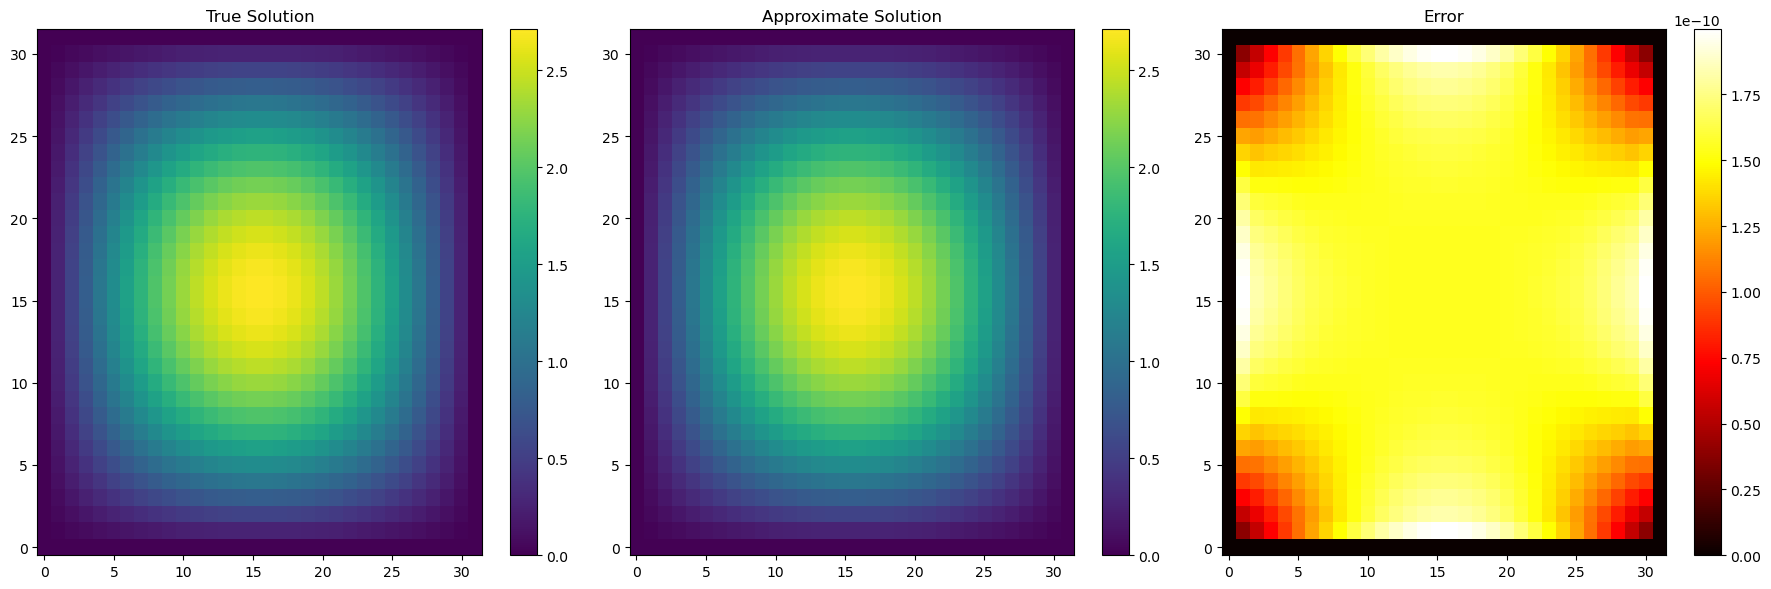

Max error: 1.7e+00, L2-error: 2.7e+01


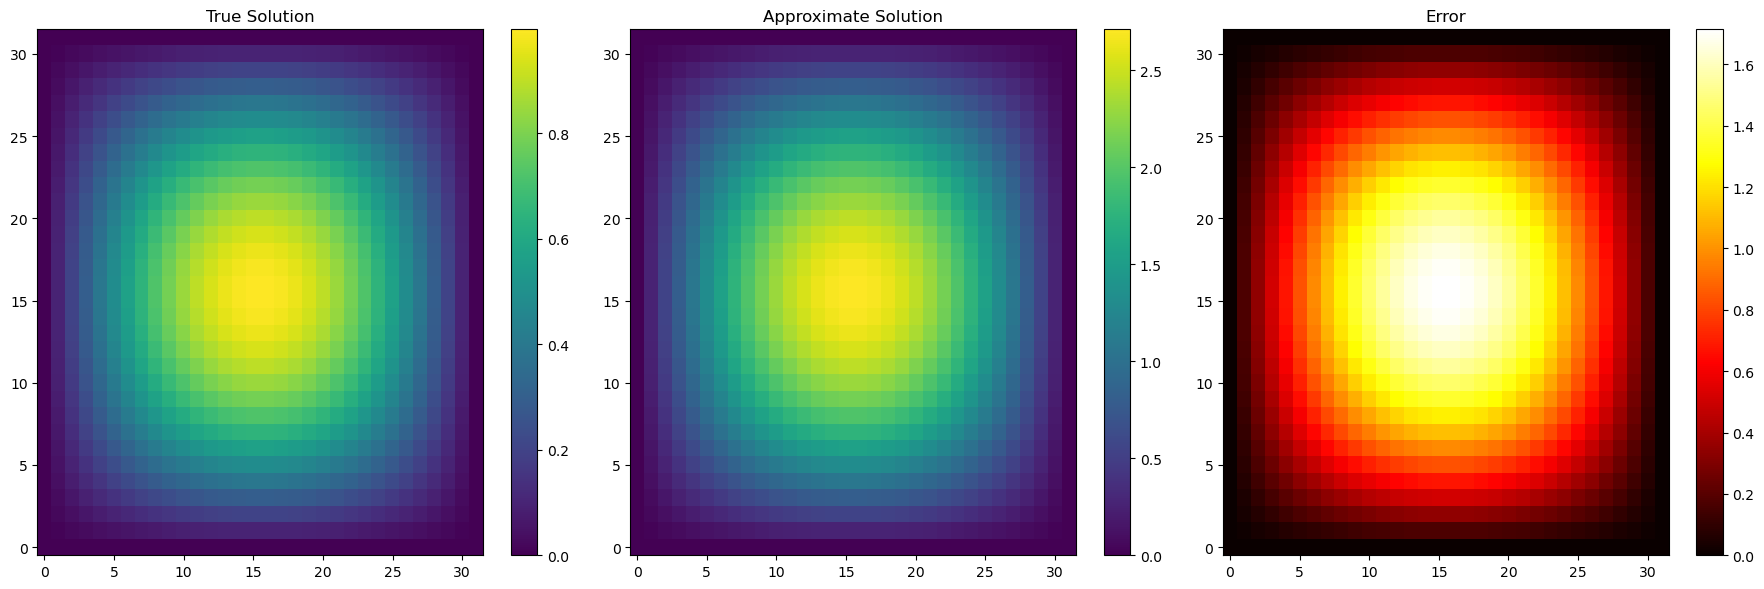

In [104]:
if(ndims == 2):
    plot_2D(true_solution, approximate_solution) # When using an iterative solver
    plot_2D(rhs, residual)

In [106]:
if(ndims == 3):
    # Adjust the max value of the slider to match the size of your 3rd dimension
    z_slider = IntSlider(min=0, max=true_solution.shape[-1]-1, step=1, value=0, description='Z index')

    # Use 'fixed' for non-interactive arguments
    interact(plot_slice_3D, true_solution=fixed(true_solution), approximate_solution=fixed(approximate_solution), error=fixed(error), z_index=z_slider)

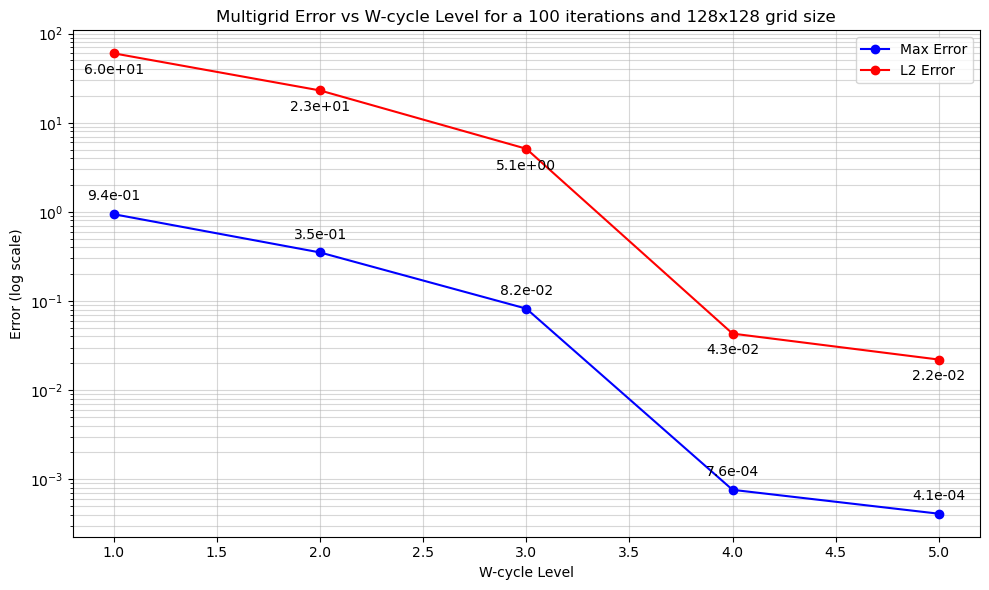

In [105]:
# Step 1: Prepare the data
w_cycle_levels = [1, 2, 3, 4, 5]
max_errors = [9.4e-01, 3.5e-01, 8.2e-02, 7.6e-04, 4.1e-04]
l2_errors = [6.0e+01, 2.3e+01, 5.1e+00, 4.3e-02, 2.2e-02]

# Step 2: Create the plot
plt.figure(figsize=(10, 6))

# Step 3: Plot Max Error
plt.semilogy(w_cycle_levels, max_errors, 'bo-', label='Max Error')

# Step 4: Plot L2 Error
plt.semilogy(w_cycle_levels, l2_errors, 'ro-', label='L2 Error')

# Step 5: Customize the plot
plt.xlabel('W-cycle Level')
plt.ylabel('Error (log scale)')
plt.title('Multigrid Error vs W-cycle Level for a 100 iterations and 128x128 grid size')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

# Step 6: Add annotations for each point
for i, (max_err, l2_err) in enumerate(zip(max_errors, l2_errors)):
    plt.annotate(f'{max_err:.1e}', (w_cycle_levels[i], max_err), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{l2_err:.1e}', (w_cycle_levels[i], l2_err), textcoords="offset points", xytext=(0,-15), ha='center')

# Step 7: Show the plot
plt.tight_layout()
plt.show()

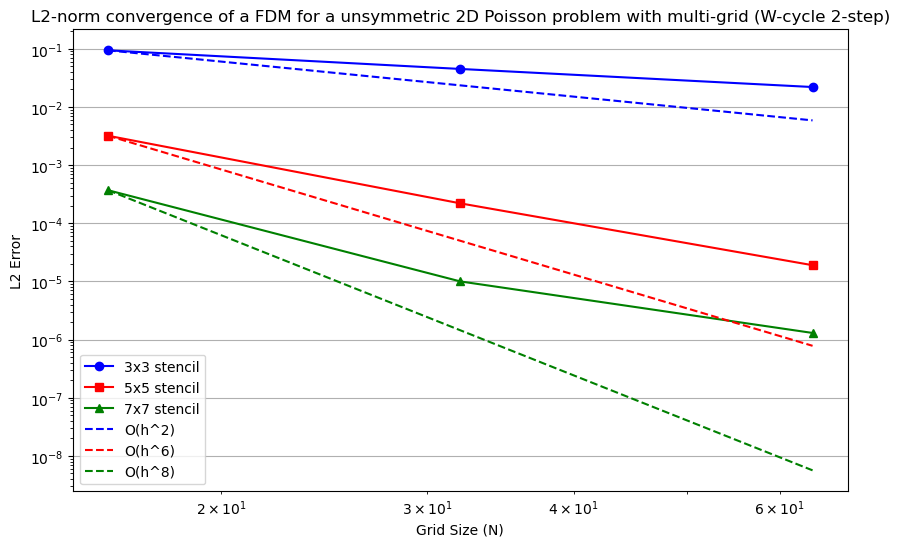

In [108]:
# CONVERGENCE PLOT FOR THE ITERATIVE METHOD

# Step 1: Prepare the data (same as before)
grid_sizes = [16, 32, 64] * 3
stencil_sizes = ['3x3'] * 3 + ['5x5'] * 3 + ['7x7'] * 3
max_errors = [1.3e-02, 3.1e-03, 7.5e-04, 6.6e-04, 2.5e-05, 8.1e-07, 6.3e-05, 8.6e-07, 4.8e-08]
l2_errors = [9.4e-02, 4.5e-02, 2.2e-02, 3.2e-03, 2.2e-04, 1.9e-05, 3.7e-04, 1.0e-05, 1.3e-06]

# Step 2: Create arrays for each stencil size (same as before)
grid_3x3 = np.array(grid_sizes[:3])
grid_5x5 = np.array(grid_sizes[3:6])
grid_7x7 = np.array(grid_sizes[6:])

# For L2 errors
error_3x3 = np.array(l2_errors[:3])
error_5x5 = np.array(l2_errors[3:6])
error_7x7 = np.array(l2_errors[6:])

# For abs values
# error_3x3 = np.array(max_errors[:3])
# error_5x5 = np.array(max_errors[3:6])
# error_7x7 = np.array(max_errors[6:])

# Step 3: Create the plot
plt.figure(figsize=(10, 6))
plt.loglog(grid_3x3, error_3x3, 'bo-', label='3x3 stencil')
plt.loglog(grid_5x5, error_5x5, 'rs-', label='5x5 stencil')
plt.loglog(grid_7x7, error_7x7, 'g^-', label='7x7 stencil')

# Step 4: Add convergence lines
grid_range = np.logspace(np.log10(16), np.log10(64), 100)
h = 1 / grid_range

# O(h^2) convergence line
c2 = error_3x3[0] * (16**2)  # Constant to match the first point of 3x3 stencil
plt.loglog(grid_range, c2 * h**2, 'b--', label='O(h^2)')

# O(h^6) convergence line
c6 = error_5x5[0] * (16**6)  # Constant to match the first point of 5x5 stencil
plt.loglog(grid_range, c6 * h**6, 'r--', label='O(h^6)')

# O(h^8) convergence line
c8 = error_7x7[0] * (16**8)  # Constant to match the first point of 7x7 stencil
plt.loglog(grid_range, c8 * h**8, 'g--', label='O(h^8)')

# Step 5: Add labels and title
plt.xlabel('Grid Size (N)')
plt.ylabel('L2 Error')
plt.title('L2-norm convergence of a FDM for a unsymmetric 2D Poisson problem with multi-grid (W-cycle 2-step)')
plt.legend()
plt.grid(True)

# Step 6: Show the plot
plt.show()

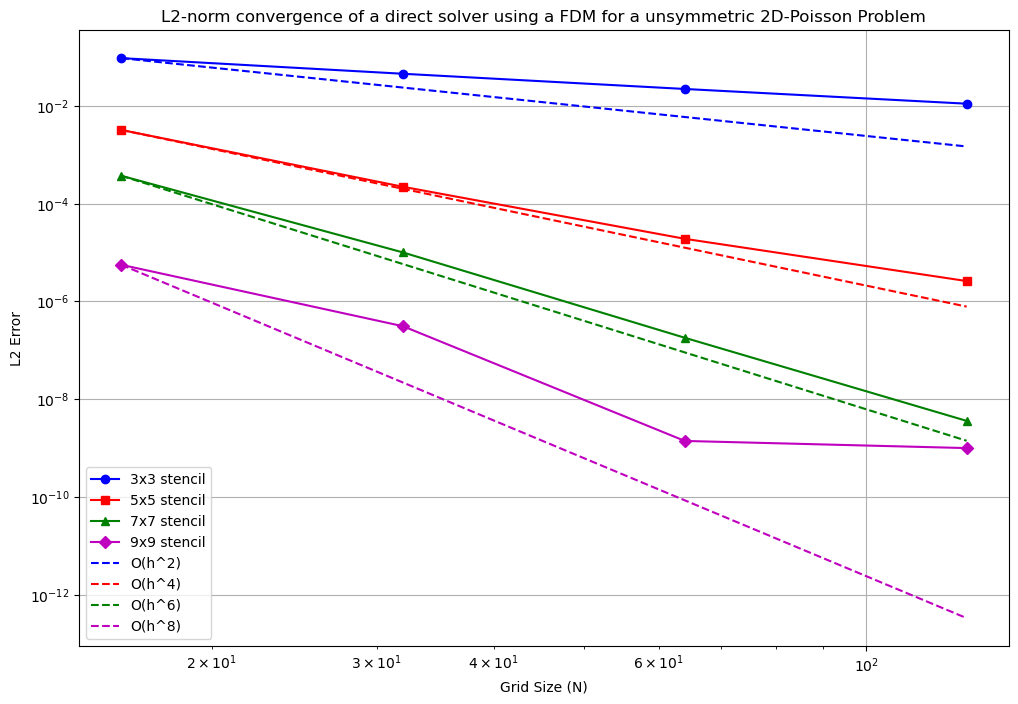

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
grid_sizes = [16, 32, 64, 128] * 4
stencil_sizes = ['3x3'] * 4 + ['5x5'] * 4 + ['7x7'] * 4 + ['9x9'] * 4
max_errors = [1.3e-02, 3.1e-03, 7.5e-04, 1.8e-04, 
              6.6e-04, 2.5e-05, 8.1e-07, 4.4e-08,
              6.3e-05, 8.6e-07, 7.1e-09, 3.4e-10,
              1.0e-06, 2.8e-08, 7.6e-11, 4.8e-10]
l2_errors = [9.4e-02, 4.5e-02, 2.2e-02, 1.1e-02,
             3.2e-03, 2.2e-04, 1.9e-05, 2.6e-06,
             3.7e-04, 1.0e-05, 1.8e-07, 3.6e-09,
             5.6e-06, 3.1e-07, 1.4e-09, 1.0e-09]

# Step 2: Create arrays for each stencil size
grid_3x3 = np.array(grid_sizes[:4])
grid_5x5 = np.array(grid_sizes[4:8])
grid_7x7 = np.array(grid_sizes[8:12])
grid_9x9 = np.array(grid_sizes[12:])

# For L2 errors
error_3x3 = np.array(l2_errors[:4])
error_5x5 = np.array(l2_errors[4:8])
error_7x7 = np.array(l2_errors[8:12])
error_9x9 = np.array(l2_errors[12:])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))
plt.loglog(grid_3x3, error_3x3, 'bo-', label='3x3 stencil')
plt.loglog(grid_5x5, error_5x5, 'rs-', label='5x5 stencil')
plt.loglog(grid_7x7, error_7x7, 'g^-', label='7x7 stencil')
plt.loglog(grid_9x9, error_9x9, 'mD-', label='9x9 stencil')

# Step 4: Add convergence lines
grid_range = np.logspace(np.log10(16), np.log10(128), 100)
h = 1 / grid_range

# O(h^2) convergence line
c2 = error_3x3[0] * (16**2)  # Constant to match the first point of 3x3 stencil
plt.loglog(grid_range, c2 * h**2, 'b--', label='O(h^2)')

# O(h^4) convergence line
c4 = error_5x5[0] * (16**4)  # Constant to match the first point of 5x5 stencil
plt.loglog(grid_range, c4 * h**4, 'r--', label='O(h^4)')

# O(h^6) convergence line
c6 = error_7x7[0] * (16**6)  # Constant to match the first point of 7x7 stencil
plt.loglog(grid_range, c6 * h**6, 'g--', label='O(h^6)')

# O(h^8) convergence line
c8 = error_9x9[0] * (16**8)  # Constant to match the first point of 9x9 stencil
plt.loglog(grid_range, c8 * h**8, 'm--', label='O(h^8)')

# Step 5: Add labels and title
plt.xlabel('Grid Size (N)')
plt.ylabel('L2 Error')
plt.title('L2-norm convergence of a direct solver using a FDM for a unsymmetric 2D-Poisson Problem')
plt.legend()
plt.grid(True)

# Step 6: Show the plot
plt.show()